In [1]:
import pandas as pd
import numpy as np
import regex as re
from collections import OrderedDict, Counter
from sklearn.utils import shuffle

### Uploading the data HDFS and performing the preprocessing on it.

In [2]:
log_file = 'HDFS_100k.log_structured.csv'

print("Loading", log_file)
struct_log = pd.read_csv(log_file, engine='c', na_filter=False, memory_map=True)

data_dict = OrderedDict()
for idx, row in struct_log.iterrows():
    blkId_list = re.findall(r'(blk_-?\d+)', row['Content'])
    blkId_set = set(blkId_list)
    for blk_Id in blkId_set:
        if not blk_Id in data_dict:
            data_dict[blk_Id] = []
        data_dict[blk_Id].append(row['EventId'])

data_df = pd.DataFrame(list(data_dict.items()), columns=['BlockId', 'EventSequence'])

Loading HDFS_100k.log_structured.csv


In [3]:
data_df

,BlockId,EventSequence
0,blk_-1608999687919862906,"[E5, E22, E5, E5, E11, E11, E9, E9, E11, E9, E..."
1,blk_7503483334202473044,"[E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E..."
2,blk_-3544583377289625738,"[E5, E22, E5, E5, E11, E9, E11, E9, E11, E9, E..."
3,blk_-9073992586687739851,"[E5, E22, E5, E5, E11, E9, E11, E9, E11, E9, E..."
4,blk_7854771516489510256,"[E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E..."
...,...,...
7935,blk_-1445970677921829671,"[E22, E5, E5, E5, E11, E9, E11, E9, E26, E26, ..."
7936,blk_-5943236831140622436,"[E22, E5, E5, E5, E26, E26, E26, E11, E9, E11,..."
7937,blk_-5039164935117450945,"[E22, E5, E5, E5, E26, E26, E11, E9, E11, E9, ..."
7938,blk_7379833155074044619,"[E22, E5, E5, E5, E26, E26, E11, E9, E11, E9, ..."


### Computes the term frequency for events in every log sequence

In [4]:
def term_frequency(values):    
    """
    values: a list of log_sequence events
    
    returns X: matrix with the term frequence for every event in the log sequences 
    """
    
    X_counts = []
    for i in range(values.shape[0]):
        event_counts = Counter(values[i])
        X_counts.append(event_counts)
    X_df = pd.DataFrame(X_counts)
    X_df = X_df.fillna(0)
    X = X_df.values
    
    return X


### Computes tf-idf of each term in the log sequence

In [5]:
def tf_idf(X):
    """    
    return X: matrix with the tf-idf for every event in the log sequences 

    """
    num_sequences = X.shape[0]
    df_vec = np.sum(X > 0, axis=0) 
    idf_vec = np.log(num_sequences / (df_vec + 1e-8))
    idf_matrix = X * np.tile(idf_vec, (num_sequences, 1)) 
    X = idf_matrix
    return X

### Normalisation of each IDF term

In [6]:
def normalise(X):
    mean_vec = X.mean(axis=0)
    mean_vec = mean_vec.reshape(1, X.shape[1])
    X = X - np.tile(mean_vec, (X.shape[0], 1))
    return X

### Data feature extraction on the dataset with the help of tf-idf

In [7]:
def preprocessing(data):
    """
    data: A dataframe with the Event_sequence column
    
    return a matrix X with the input vectorized with respect to tf-idf
    """
    values = data.iloc[:,1]
    X = term_frequency(values)
    X = tf_idf(X)
    X = normalise(X)
    
    return X
    

### Shuffle the rows

In [8]:
data_df = data_df.sample(frac=1, axis=0).reset_index(drop=True)

###  Preprocessing of the data

In [9]:
X = preprocessing(data_df)

#### Since the data is huge, we will perform hierarchichal clustering in two phases. In the first phase we create the representative log sequences for the clusters for a set of 1000 log sequences. Then in the next phase, we update the centroid with incoming log sequence instances.


In [10]:
from numpy import linalg as LA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

In [11]:
def distance_metric(x1, x2):
    """
    Computes cosine similarity among the vectors x1 and x2
    """
    norm= LA.norm(x1) * LA.norm(x2)
    distance = 1 - np.dot(x1, x2) / (norm + 1e-8)
    if distance < 1e-8:
        distance = 0
    return distance

def get_min_cluster_dist(instance_vec, reps):
    """
    Computes the minimum distance of the instance log sequence with reference to the representative log sequences
    
    Returns the minimum distance and the index of the cluster it is the nearest to.
    """
    min_index = -1
    min_dist = float('inf')
    for i in range(len(reps)):
        cluster_rep = reps[i]
        dist = distance_metric(instance_vec, cluster_rep)
        if dist < 1e-8:
            min_dist = 0
            min_index = i
            break
        elif dist < min_dist:
            min_dist = dist
            min_index = i
    return min_dist, min_index


## First phase

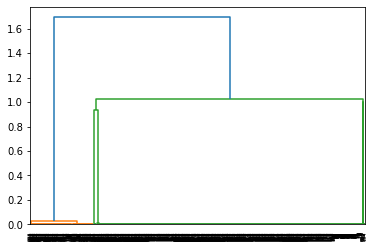

In [12]:
max_dist = 0.3

X_bootstrap = X[0: 1000, :]
p_dist = pdist(X_bootstrap, metric= distance_metric)
Z = linkage(p_dist, 'complete')
cluster_index = fcluster(Z, max_dist, criterion='distance')

dn = dendrogram(Z)
plt.show()


### Find the representative log sequences from the clusters obtained from linkage matrix and compute the cluster size for each cluster

In [13]:
representatives = list()
cluster_size_dict = dict()


num_clusters = len(set(cluster_index))
for clu in range(num_clusters):
    clu_idx = np.argwhere(cluster_index == clu + 1)[:, 0]
    
    cluster_size_dict[clu] = clu_idx
    repre_center = np.average(X[clu_idx, :], axis=0)
    representatives.append(repre_center)

# print(len(representatives))
# print(cluster_size_dict)

## Second phase
#### Add the new instances to the existing clusters or form a new cluster depending on the distance threshold

In [14]:
for i in range(1000, X.shape[0]):
    if (i + 1) % 2000 == 0:
        print('Processed {} instances.'.format(i + 1))
    instance_vec = X[i, :]
    
    if len(representatives) > 0:
        min_dist, clu_id = get_min_cluster_dist(instance_vec, representatives)
        if min_dist <= max_dist:
            cluster_size_dict[clu_id] = np.append(cluster_size_dict[clu_id], i)
            representatives[clu_id] = representatives[clu_id] + (instance_vec - representatives[clu_id]) \
                                         / len(cluster_size_dict[clu_id])
            continue
    cluster_size_dict[len(representatives)] = np.array([i])
    representatives.append(instance_vec)

print('Processed {} instances.'.format(X.shape[0]))
print('Found {} clusters.\n'.format(len(representatives)))


Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 7940 instances.
Found 8 clusters.



### After comple,on of both phases, 8 clusters were found

In [15]:
cluster_size_dict

{0: array([  27,   30,   35, ..., 7917, 7921, 7937], dtype=int64),
 1: array([ 441,  567,  608,  636,  670,  733,  752,  878,  961, 1024, 1102,
        1234, 1348, 1447, 1452, 1500, 1586, 2024, 2096, 2303, 2316, 2344,
        2351, 2482, 2622, 2626, 2656, 2730, 2732, 2780, 2795, 2992, 3032,
        3274, 3569, 3681, 4220, 4271, 4661, 4684, 4814, 5151, 5369, 5413,
        5433, 5562, 5745, 5946, 6357, 6379, 6386, 6487, 6554, 6574, 7083,
        7117, 7226, 7272, 7337, 7508, 7549, 7695, 7737], dtype=int64),
 2: array([   0,    1,    2, ..., 7936, 7938, 7939], dtype=int64),
 3: array([  82,  134,  242,  519,  898,  983, 1154, 1370, 1630, 2321, 2772,
        2858, 3564, 3804, 4626, 4884, 5816, 6175, 6362, 6699, 6924, 7255],
       dtype=int64),
 4: array([ 870, 2966, 3246, 4295, 5311, 6657, 7643, 7853], dtype=int64),
 5: array([2577]),
 6: array([3000, 4555, 6992]),
 7: array([4141, 6793])}

In [16]:
def get_representative(log_array, centroid):
    """
    Returns the representative cluster based on the minimum distance from the centroid.
    """
    min_index = -1
    min_dist = float('inf')
    
    for i in range(len(log_array)):
        instance_vec = X[log_array[i],:]
        
        dist = distance_metric(instance_vec, centroid)
        
        if dist < min_dist:
            min_dist = dist
            min_index = i
    
    return log_array[min_index]

### Get the representative of each cluster:

In [17]:
for i in range(len(representatives)):

    log_array = cluster_size_dict[i]
    centroid = representatives[i]
    z = get_representative(log_array, centroid)
    
    print("Representative for cluster {}:\n".format(i))
    print(data_df.iloc[z,:])
    print('=============================================================\n\n')

Representative for cluster 0:

BlockId                                    blk_7946935699456709525
EventSequence    [E5, E5, E22, E5, E11, E11, E9, E9, E11, E9, E...
Name: 57, dtype: object


Representative for cluster 1:

BlockId          blk_6006300655294348209
EventSequence          [E22, E5, E5, E7]
Name: 441, dtype: object


Representative for cluster 2:

BlockId                                   blk_-1125562161725129359
EventSequence    [E22, E5, E5, E5, E26, E26, E11, E9, E11, E9, ...
Name: 0, dtype: object


Representative for cluster 3:

BlockId                                   blk_-6739860488313725269
EventSequence    [E22, E5, E5, E5, E26, E26, E11, E9, E11, E9, ...
Name: 82, dtype: object


Representative for cluster 4:

BlockId                                    blk_7233483060617031024
EventSequence    [E22, E5, E5, E5, E13, E13, E13, E26, E26, E26...
Name: 870, dtype: object


Representative for cluster 5:

BlockId                                    blk_388863585040984956